In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Lecture des fichiers des donnees a classifier

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

# Affichage aleatoire de quelques donnees de databae

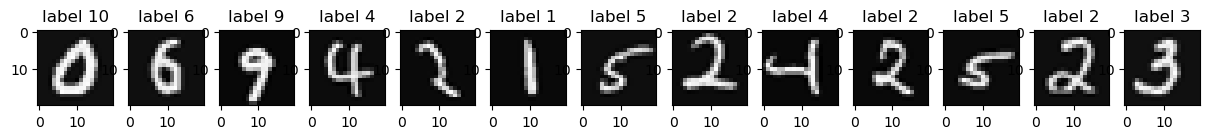

In [5]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset
    a = X[c,:].reshape((20, 20)) #shape of one number in the image
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

# **Implementations des metriques demandées **

# Matrice de confusion

In [7]:
def matrice_confusion(Y_true, Y_pred, num_classes=10):
     # Initialisation de la matrice de confusion avec des zéros
    cm = np.zeros((num_classes , num_classes), dtype=int)
    # Remplissage de la matrice de confusion
    for true, pred in zip(Y_true, Y_pred):
        cm[0 if true == 10 else true, 0 if pred == 10 else pred] += 1  # Incrémentation à la position correspondante

    # Calcul des TP, TN, FP, FN pour chaque classe
    metrics = {}
    for i in range(num_classes):
        TP = cm[i, i]  # Vrais Positifs (diagonale)
        FP = np.sum(cm[:, i]) - TP  # Faux Positifs (colonne)
        FN = np.sum(cm[i, :]) - TP  # Faux Négatifs (ligne)
        TN = np.sum(cm) - (TP + FP + FN)  # Tout le reste

        metrics[i] = {"TP": TP, "TN": TN, "FP": FP, "FN": FN}

    return cm, metrics

Matrice confusion (python)

In [8]:
def confusion(Y_true, Y_pred, num_classes=10):

    # Étape 1 : Calcul de la matrice de confusion
    cm1 = confusion_matrix(Y_true, Y_pred, labels=range(num_classes))

    # Étape 2 : Calcul des TP, TN, FP, FN pour chaque classe
    metrics1 = {}  # Dictionnaire pour stocker les valeurs

    for i in range(num_classes):
        TP1 = cm1[i, i]  # Vrais Positifs (diagonale)
        FP1 = np.sum(cm1[:, i]) - TP1  # Faux Positifs (colonne de la classe)
        FN1 = np.sum(cm1[i, :]) - TP1  # Faux Négatifs (ligne de la classe)
        TN1 = np.sum(cm1) - (TP1 + FP1 + FN1)  # Tout le reste

        metrics1[i] = {"TP": TP1, "TN": TN1, "FP": FP1, "FN": FN1}

    return cm1, metrics1

# Accuracy = (TP + TN)/(TP + TN + FP +FN)

In [10]:
def calcul_accuracy(metrics):

    class_accuracies = {}
    for cls, values in metrics.items():
        total = values["TP"] + values["TN"] + values["FP"] + values["FN"]
        class_accuracies[cls] = (values["TP"] + values["TN"]) / total if total > 0 else 0

    return class_accuracies

# Recall (true positive rate) = TP/(TP + FN)

In [11]:
def calcul_recall(metrics):
    class_recalls = {}

    for cls, values in metrics.items():
        total = values["TP"] + values["FN"]
        class_recalls[cls] = values["TP"] / total if total > 0 else 0

    return class_recalls

# precision = TP/(TP + FP)

In [12]:
def calcul_precision(metrics):
    class_precisions = {}

    for cls, values in metrics.items():
        total = values["TP"] + values["FP"]
        class_precisions[cls] = values["TP"] / total if total > 0 else 0

    return class_precisions

# Taux de FP (false positive rate) = FP /(FP + TN)

In [13]:
def calcul_fpr(metrics):
    class_fpr = {}

    for cls, values in metrics.items():
        total = values["FP"] + values["TN"]
        class_fpr[cls] = values["FP"] / total if total > 0 else 0

    return class_fpr

# Specificite(True negative rate) = TN /(TN + FP)

In [14]:
def calcul_specificite(metrics):
    class_specificity = {}

    for cls, values in metrics.items():
        total = values["TN"] + values["FP"]
        class_specificity[cls] = values["TN"] / total if total > 0 else 0

    return class_specificity

# Courbe ROC

In [15]:


# Calcul de la courbe ROC "from scratch"
def calculer_courbe_roc_from_scratch(y_true, y_score,classe):
    y_score_classe = y_score[:,classe]
    thresholds = np.sort(np.unique(y_score))[::-1]
    tpr = []
    fpr = []
    positif = np.sum(y_true == 1)
    negatif = np.sum(y_true == 0)

    for seuil in thresholds:
        predictions = (y_score_classe >= seuil).astype(int)
        tp = np.sum((predictions == 1) & (y_true == 1))
        fp = np.sum((predictions == 1) & (y_true == 0))
        fn = np.sum((predictions == 0) & (y_true == 1))
        tn = np.sum((predictions == 0) & (y_true == 0))

        tpr.append(tp / positif)
        fpr.append(fp / negatif)

    tpr = np.array(tpr)
    fpr = np.array(fpr)

    auc_score = np.trapz(tpr, fpr)

    # Affichage de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'Courbe ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title(f'Courbe ROC - Classe {classe}')
    plt.legend(loc='lower right')
    plt.show()

    return fpr, tpr, auc_score

# **Classification**

In [16]:
scaler = StandardScaler()
scaler.fit(X) #Calcule la moyenne et l'écart type de X
scaled_features = scaler.transform(X) #données normalisées (features)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Methode 0 : KNN

k=1, Accuracy=0.8647
k=3, Accuracy=0.8700
k=5, Accuracy=0.8767
k=7, Accuracy=0.8753
k=9, Accuracy=0.8740

 Meilleur k: 5 avec une précision de 0.8767


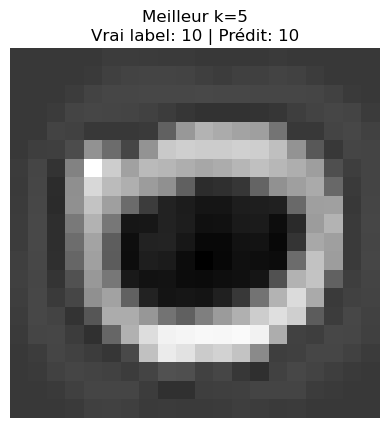

In [17]:
from scipy.spatial.distance import cdist
from scipy.stats import mode
# 🚀 Optimisation du calcul des distances avec cdist
def knn_classifier(x_train, y_train, x_test, k):
    # Calcul des distances entre x_test et x_train (matrice de distances)
    distances = cdist(x_test, x_train, metric="euclidean")

    # Indices des k plus proches voisins
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]

    # Récupération des labels correspondants
    k_nearest_labels = np.take(y_train, k_nearest_indices)

    # Vote majoritaire optimisé
    y_pred = np.apply_along_axis(lambda x: mode(x, keepdims=True).mode[0], axis=1, arr=k_nearest_labels)

    return y_pred

# 🔹 Fonction pour afficher une image avec la prédiction
def show_image(image, true_label, predicted_label, title=""):
    size = int(np.sqrt(image.shape[0]))  # Calcul de la taille de l'image
    plt.imshow(image.reshape((size, size)), cmap="gray")
    plt.title(f"{title}\nVrai label: {true_label} | Prédit: {predicted_label}")
    plt.axis("off")
    plt.show()

# 🔍 Recherche du meilleur k
best_k, best_accuracy = None, 0
accuracies = {}

# Tester k impairs entre 1 et 9
for k in range(1, 10, 2):
    y_pred = knn_classifier(Xt, Yt, Xtt, k)
    accuracy = np.mean(y_pred == Ytt)  # Calcul de l'accuracy
    accuracies[k] = accuracy

    print(f"k={k}, Accuracy={accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy, best_k = accuracy, k

#  Affichage du meilleur k
print(f"\n Meilleur k: {best_k} avec une précision de {best_accuracy:.4f}")

# 🔹 Afficher une image test + prédiction pour le meilleur k
if len(Xtt) > 0:
    c = np.random.randint(0, len(Xtt))  # Choisir une image aléatoire
    show_image(Xtt[c], Ytt[c], knn_classifier(Xt, Yt, Xtt[c:c+1], best_k)[0], title=f"Meilleur k={best_k}")

k=1, Accuracy=0.8647
k=3, Accuracy=0.8700
k=5, Accuracy=0.8767
k=7, Accuracy=0.8753
k=9, Accuracy=0.8740

 Meilleur k: 5 avec une précision de 0.8767


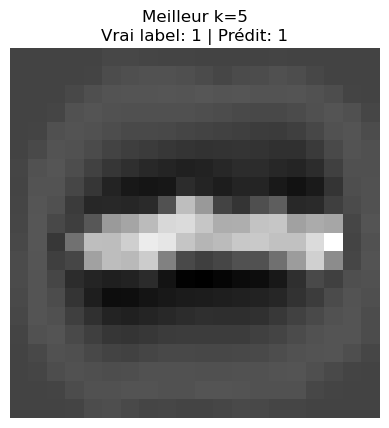

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 🚀 Utilisation de KNeighborsClassifier
def knn_classifier_sklearn(x_train, y_train, x_test, k):
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

# 🔹 Fonction pour afficher une image avec la prédiction
def show_image(image, true_label, predicted_label, title=""):
    size = int(np.sqrt(image.shape[0]))  # Calcul de la taille de l'image
    plt.imshow(image.reshape((size, size)), cmap="gray")
    plt.title(f"{title}\nVrai label: {true_label} | Prédit: {predicted_label}")
    plt.axis("off")
    plt.show()

# 🔍 Recherche du meilleur k
best_k, best_accuracy = None, 0
accuracies = {}

# Tester k impairs entre 1 et 9
for k in range(1, 10, 2):
    y_pred = knn_classifier_sklearn(Xt, Yt, Xtt, k)
    accuracy = np.mean(y_pred == Ytt)  # Calcul de l'accuracy
    accuracies[k] = accuracy

    print(f"k={k}, Accuracy={accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy, best_k = accuracy, k

#  Affichage du meilleur k
print(f"\n Meilleur k: {best_k} avec une précision de {best_accuracy:.4f}")

# 🔹 Afficher une image test + prédiction pour le meilleur k
if len(Xtt) > 0:
    c = np.random.randint(0, len(Xtt))  # Choisir une image aléatoire
    show_image(Xtt[c], Ytt[c], knn_classifier_sklearn(Xt, Yt, Xtt[c:c+1], best_k)[0], title=f"Meilleur k={best_k}")


## Matrice de confusion KNN

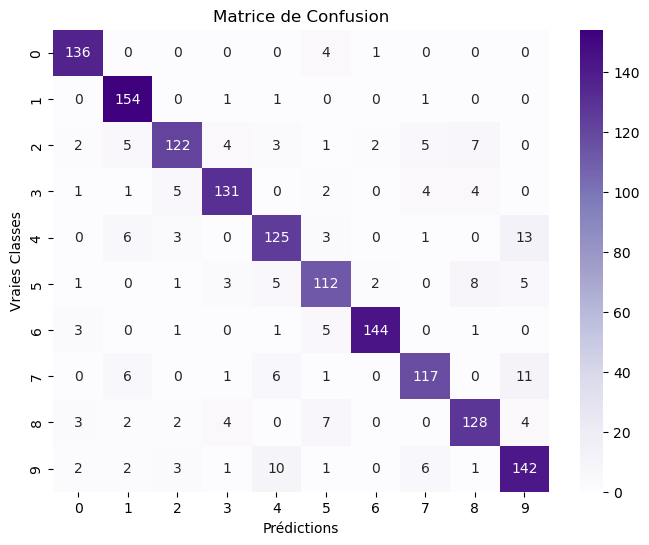

In [19]:
import seaborn as sns

cm, metrics = matrice_confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [20]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")
df_metrics.index.name = "Classe"
df_metrics.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  136 │ 1347 │   12 │    5 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  154 │ 1321 │   22 │    3 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  122 │ 1334 │   15 │   29 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │  131 │ 1338 │   14 │   17 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  125 │ 1323 │   26 │   26 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │  112 │ 1339 │   24 │   25 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  144 │ 1340 │    5 │   11 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  117 │ 1341 │   17 │   25 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │  128 │ 1329 │   21 │   22 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  142 │ 1299 │   33 │   26 │
╘══════════╧══════╧══════╧══════╧══════╛


## Martrice confusion KNN (python)

In [21]:
Ytt = np.where(Ytt == 10, 0, Ytt)
y_pred = np.where(y_pred == 10, 0, y_pred)

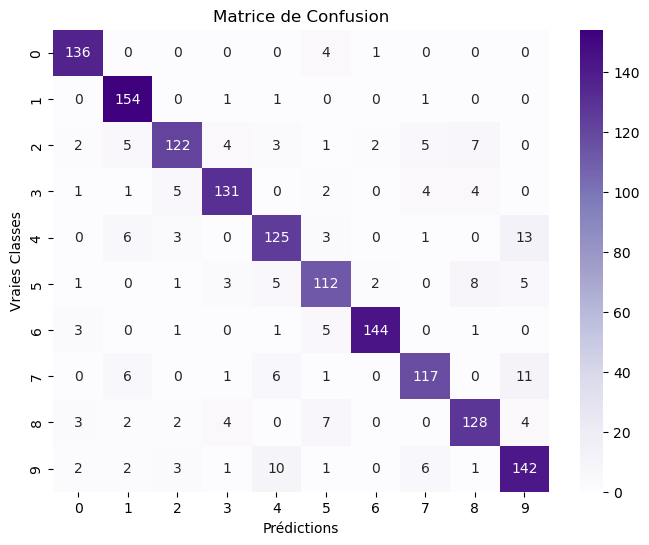

In [22]:
cm1, metrics1 = confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Purples", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [20]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics1 = pd.DataFrame.from_dict(metrics1, orient="index")
df_metrics1.index.name = "Classe"
df_metrics1.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics1, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  140 │ 1341 │    9 │   10 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  149 │ 1312 │   37 │    2 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  127 │ 1327 │   11 │   35 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │  144 │ 1313 │   31 │   12 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  109 │ 1338 │   27 │   26 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │  112 │ 1334 │   18 │   36 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  139 │ 1341 │   10 │   10 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  118 │ 1344 │   15 │   23 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │  123 │ 1327 │   23 │   27 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  129 │ 1313 │   29 │   29 │
╘══════════╧══════╧══════╧══════╧══════╛


Metriques KNN

Accuracy KNN

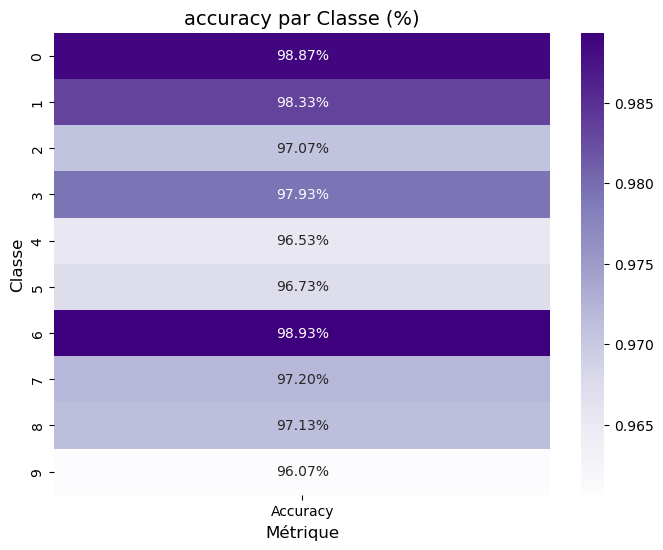

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
class_accuracies = calcul_accuracy(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(class_accuracies.keys())
accuracies = np.array(list(class_accuracies.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracies, annot=True, fmt=".2%", cmap="Purples", xticklabels=["Accuracy"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("accuracy par Classe (%)", fontsize=14)

# Affichage
plt.show()

Recal KNN

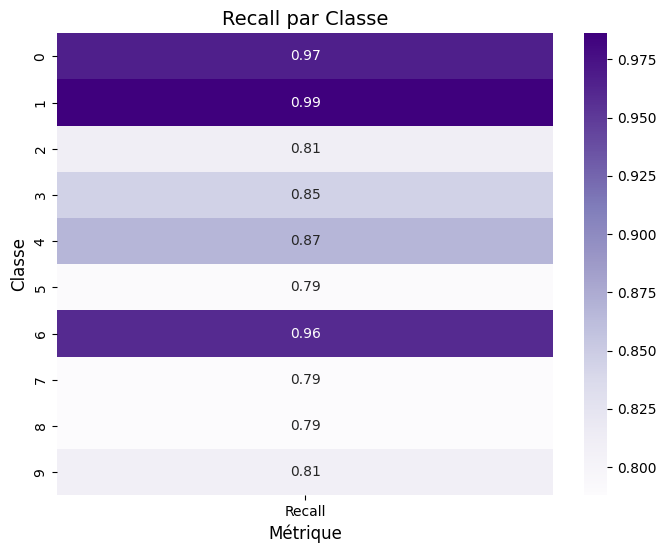

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des recalls par classe
recalls = calcul_recall(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(recalls.keys())
recall_values = np.array(list(recalls.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(recall_values, annot=True, fmt=".2f", cmap="Purples", xticklabels=["Recall"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Recall par Classe", fontsize=14)

# Affichage
plt.show()

Precision KNN

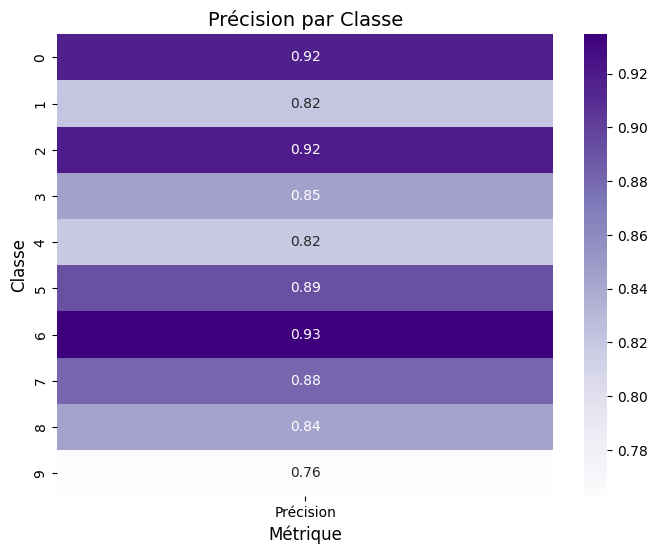

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
precisions = calcul_precision(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(precisions.keys())
precision_values = np.array(list(precisions.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(precision_values, annot=True, fmt=".2f", cmap="Purples", xticklabels=["Précision"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe", fontsize=14)

# Affichage
plt.show()


Taux de FP

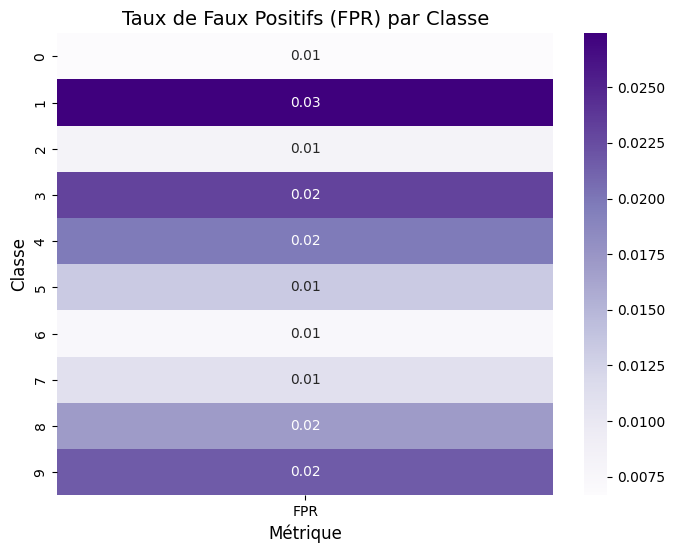

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul du taux de faux positifs (FPR) par classe
fpr_values = calcul_fpr(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(fpr_values.keys())
fpr_matrix = np.array(list(fpr_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fpr_matrix, annot=True, fmt=".2f", cmap="Purples", xticklabels=["FPR"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Taux de Faux Positifs (FPR) par Classe", fontsize=14)

# Affichage
plt.show()

Specificite KNN

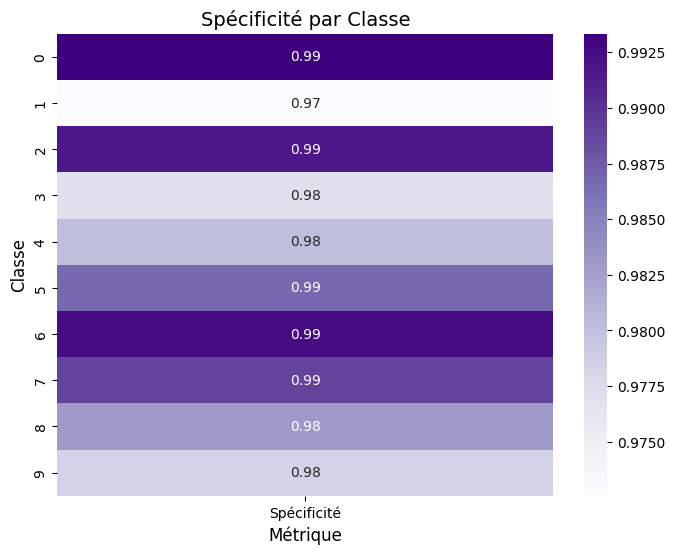

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la spécificité par classe
specificity_values = calcul_specificite(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(specificity_values.keys())
specificity_matrix = np.array(list(specificity_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(specificity_matrix, annot=True, fmt=".2f", cmap="Purples", xticklabels=["Spécificité"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Spécificité par Classe", fontsize=14)

# Affichage
plt.show()


In [25]:
class_labels = np.unique(Ytt)  # np.unique(Ytt) pour récupérer les labels uniques


In [26]:
print(classification_report(Ytt, y_pred, target_names=[f"Classe {i}" for i in class_labels]))


              precision    recall  f1-score   support

    Classe 0       0.92      0.97      0.94       148
    Classe 1       0.82      0.99      0.90       145
    Classe 2       0.92      0.81      0.86       154
    Classe 3       0.85      0.85      0.85       155
    Classe 4       0.82      0.87      0.84       166
    Classe 5       0.89      0.79      0.84       167
    Classe 6       0.93      0.96      0.95       149
    Classe 7       0.88      0.79      0.83       132
    Classe 8       0.84      0.79      0.82       137
    Classe 9       0.76      0.81      0.79       147

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



# Methode 1 : MVS

In [ ]:
#Créer le modèle
model= svm.SVC(kernel='linear')
# entrainement
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

1


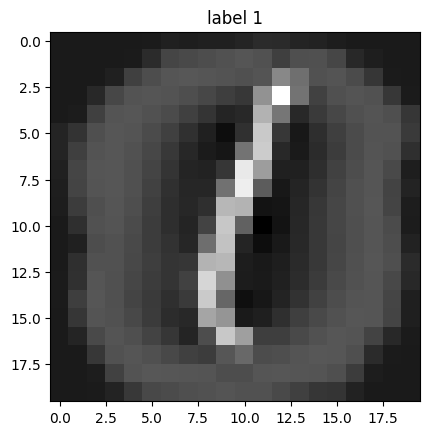

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

## Matrice de confusion MVS

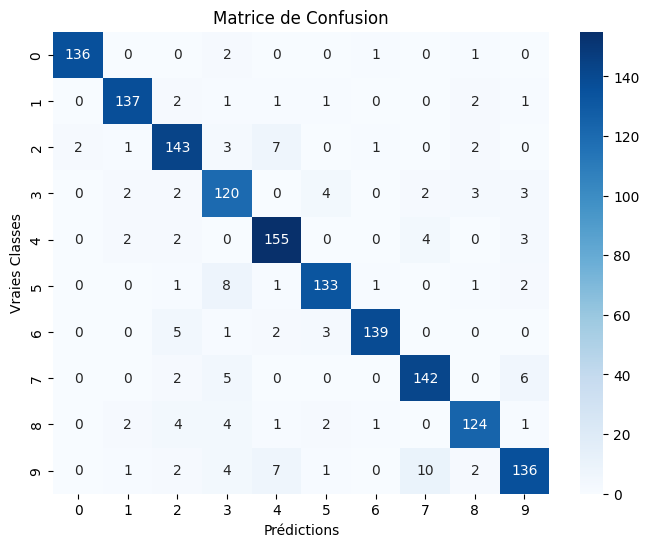

In [ ]:
import seaborn as sns

cm, metrics = matrice_confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()


In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")
df_metrics.index.name = "Classe"
df_metrics.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics, headers="keys", tablefmt="fancy_grid"))


╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  136 │ 1358 │    2 │    4 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  137 │ 1347 │    8 │    8 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  143 │ 1321 │   20 │   16 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │  120 │ 1336 │   28 │   16 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  155 │ 1315 │   19 │   11 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │  133 │ 1342 │   11 │   14 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  139 │ 1346 │    4 │   11 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  142 │ 1329 │   16 │   13 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │  124 │ 1350 │   11 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  136 │ 1321 │   16 │   27 │
╘══════════╧══════╧══════╧══════╧══════╛


Matrice confusion (python)

In [ ]:
Ytt = np.where(Ytt == 10, 0, Ytt)
y_pred = np.where(y_pred == 10, 0, y_pred)

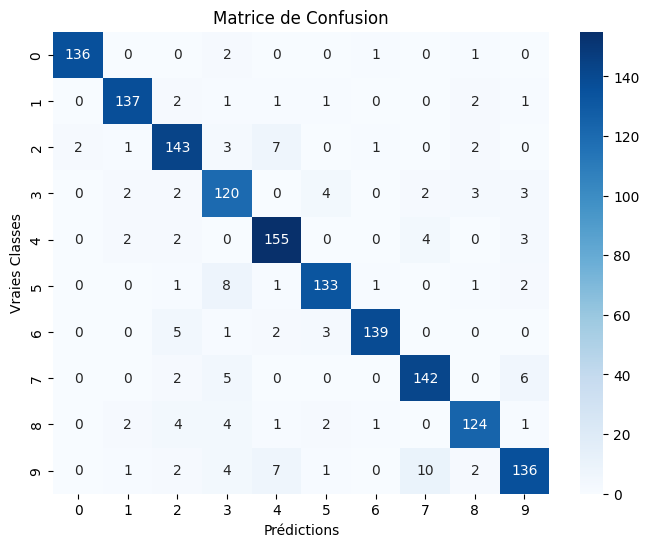

In [ ]:
cm1, metrics1 = confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics1 = pd.DataFrame.from_dict(metrics1, orient="index")
df_metrics1.index.name = "Classe"
df_metrics1.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics1, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  136 │ 1358 │    2 │    4 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  137 │ 1347 │    8 │    8 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  143 │ 1321 │   20 │   16 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │  120 │ 1336 │   28 │   16 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  155 │ 1315 │   19 │   11 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │  133 │ 1342 │   11 │   14 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  139 │ 1346 │    4 │   11 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  142 │ 1329 │   16 │   13 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │  124 │ 1350 │   11 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  136 │ 1321 │   16 │   27 │
╘══════════╧══════╧══════╧══════╧══════╛


## **Calcul des metriques**

## Accuracy MVS

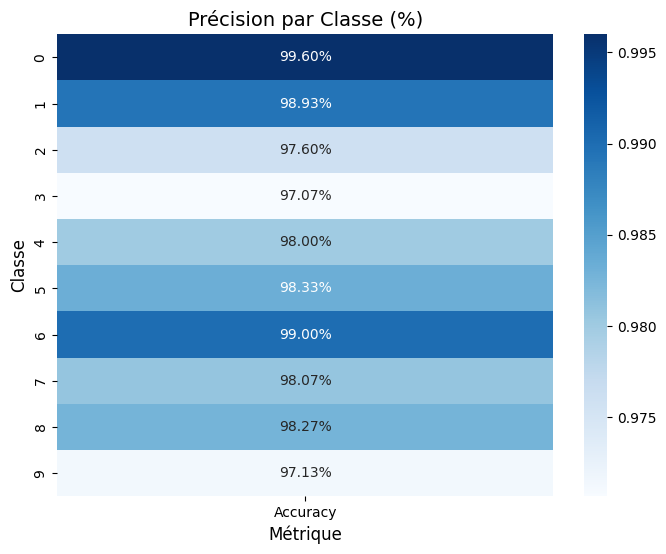

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
class_accuracies = calcul_accuracy(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(class_accuracies.keys())
accuracies = np.array(list(class_accuracies.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracies, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Accuracy"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe (%)", fontsize=14)

# Affichage
plt.show()

## Recall MVS

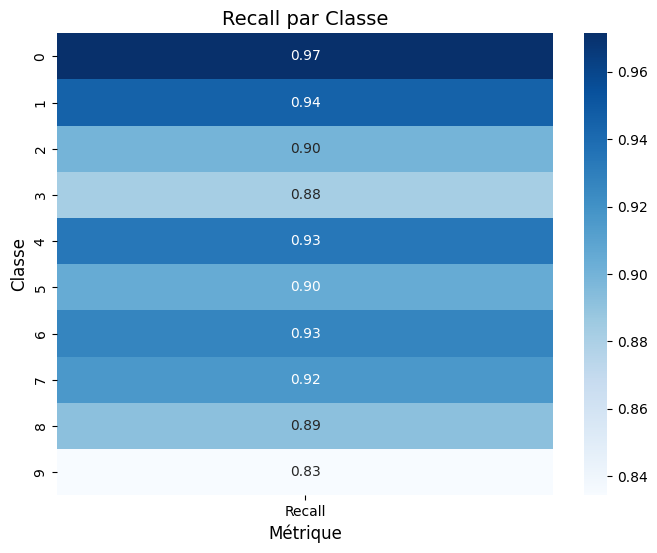

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des recalls par classe
recalls = calcul_recall(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(recalls.keys())
recall_values = np.array(list(recalls.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(recall_values, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Recall"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Recall par Classe", fontsize=14)

# Affichage
plt.show()


## Precision MVS

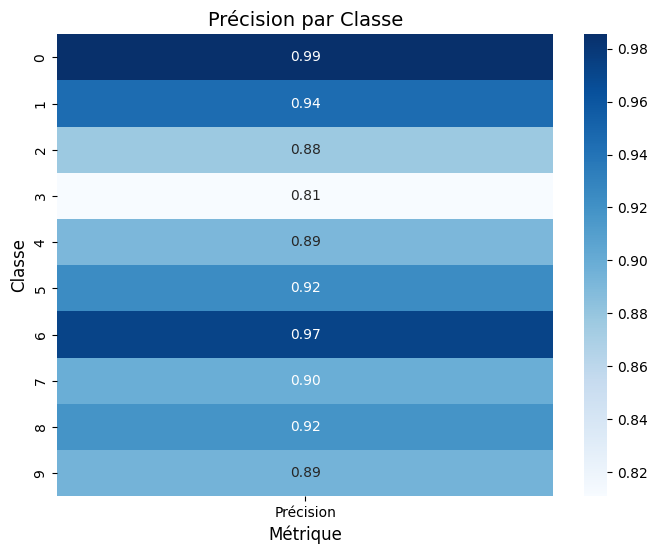

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
precisions = calcul_precision(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(precisions.keys())
precision_values = np.array(list(precisions.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(precision_values, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Précision"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe", fontsize=14)

# Affichage
plt.show()


## Taux de FP *MVS*

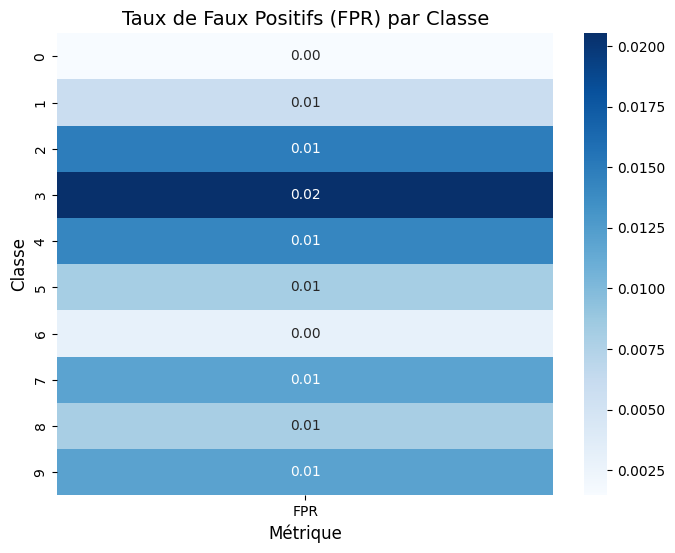

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul du taux de faux positifs (FPR) par classe
fpr_values = calcul_fpr(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(fpr_values.keys())
fpr_matrix = np.array(list(fpr_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fpr_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["FPR"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Taux de Faux Positifs (FPR) par Classe", fontsize=14)

# Affichage
plt.show()


## Specificite

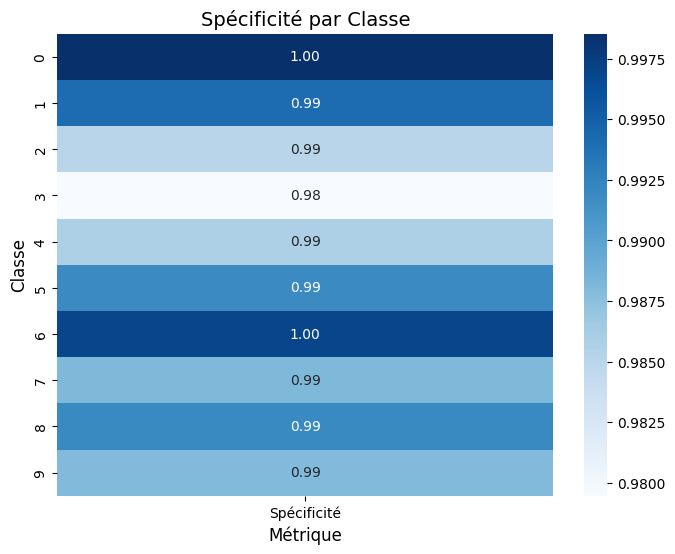

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la spécificité par classe
specificity_values = calcul_specificite(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(specificity_values.keys())
specificity_matrix = np.array(list(specificity_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(specificity_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Spécificité"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Spécificité par Classe", fontsize=14)

# Affichage
plt.show()


# Methode 2 : Arbres de *decision*

In [ ]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

1


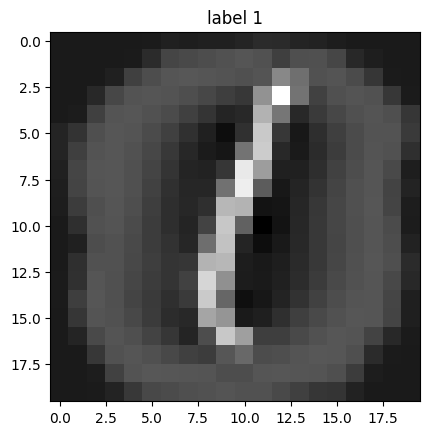

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

### Matrice de confusion Arbres de decision

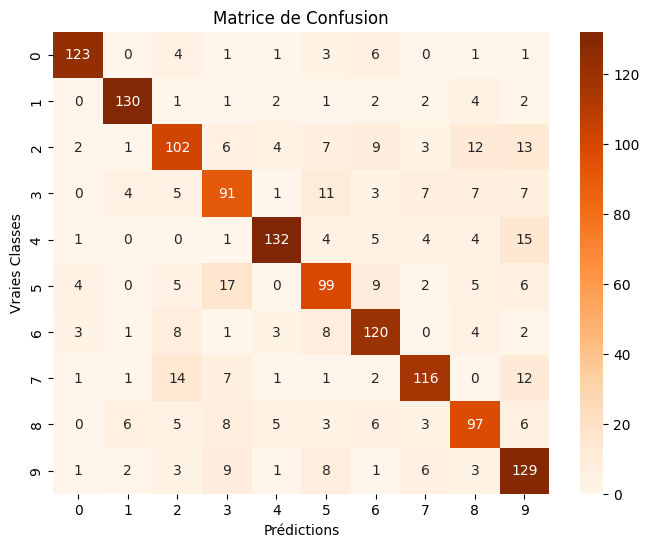

In [ ]:
import seaborn as sns

cm, metrics = matrice_confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")
df_metrics.index.name = "Classe"
df_metrics.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  123 │ 1348 │   12 │   17 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  130 │ 1340 │   15 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  102 │ 1296 │   45 │   57 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │   91 │ 1313 │   51 │   45 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  132 │ 1316 │   18 │   34 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │   99 │ 1307 │   46 │   48 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  120 │ 1307 │   43 │   30 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  116 │ 1318 │   27 │   39 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │   97 │ 1321 │   40 │   42 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  129 │ 1273 │   64 │   34 │
╘══════════╧══════╧══════╧══════╧══════╛


### Matrice de confusion (python) Arbre de decision


In [ ]:
Ytt = np.where(Ytt == 10, 0, Ytt)
y_pred = np.where(y_pred == 10, 0, y_pred)

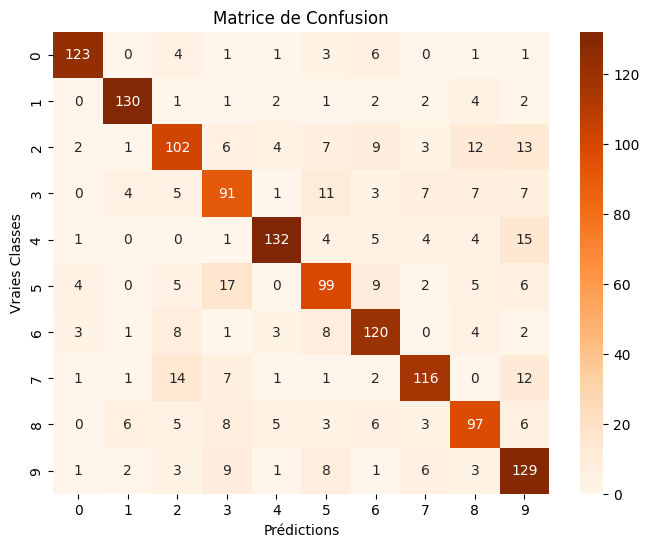

In [ ]:
cm1, metrics1 = confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics1 = pd.DataFrame.from_dict(metrics1, orient="index")
df_metrics1.index.name = "Classe"
df_metrics1.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics1, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  123 │ 1348 │   12 │   17 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  130 │ 1340 │   15 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  102 │ 1296 │   45 │   57 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │   91 │ 1313 │   51 │   45 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  132 │ 1316 │   18 │   34 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │   99 │ 1307 │   46 │   48 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  120 │ 1307 │   43 │   30 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  116 │ 1318 │   27 │   39 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │   97 │ 1321 │   40 │   42 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  129 │ 1273 │   64 │   34 │
╘══════════╧══════╧══════╧══════╧══════╛


Metriques Arbres de decision

Metriques Arbres de decision

### Accuracy

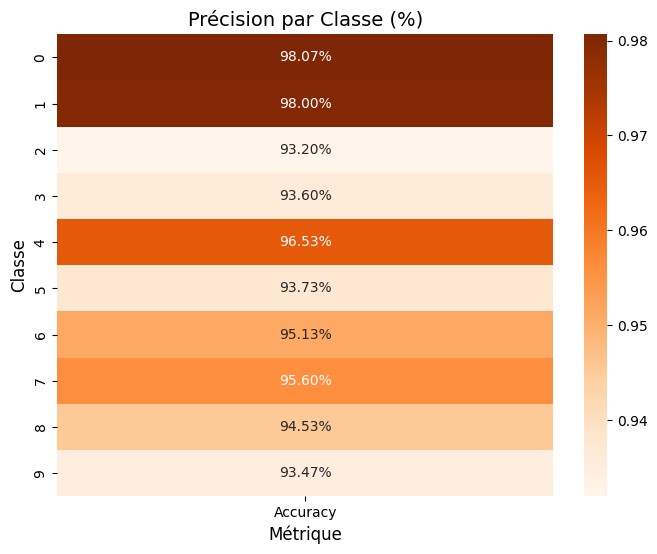

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
class_accuracies = calcul_accuracy(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(class_accuracies.keys())
accuracies = np.array(list(class_accuracies.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracies, annot=True, fmt=".2%", cmap="Oranges", xticklabels=["Accuracy"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe (%)", fontsize=14)

# Affichage
plt.show()

### Recall

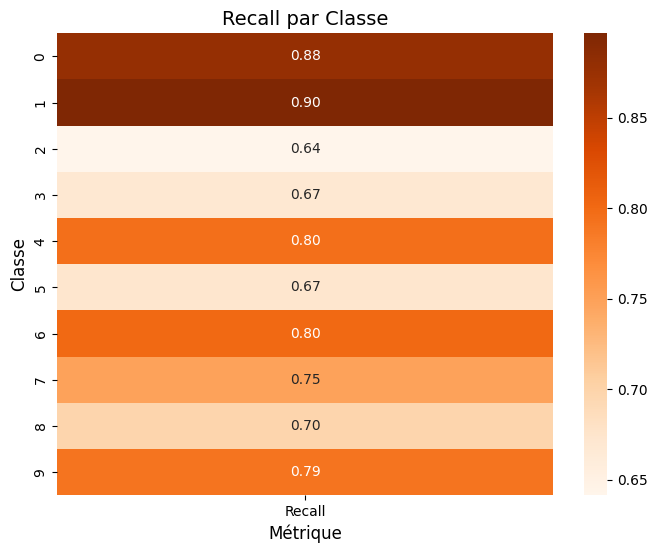

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des recalls par classe
recalls = calcul_recall(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(recalls.keys())
recall_values = np.array(list(recalls.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(recall_values, annot=True, fmt=".2f", cmap="Oranges", xticklabels=["Recall"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Recall par Classe", fontsize=14)

# Affichage
plt.show()

### precision

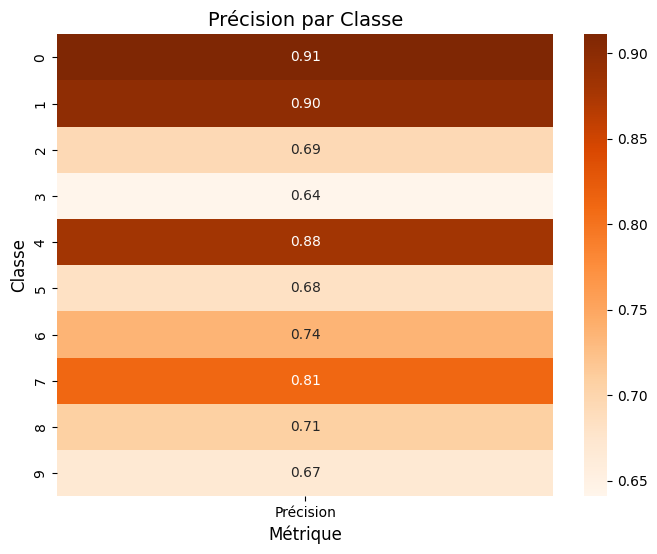

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
precisions = calcul_precision(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(precisions.keys())
precision_values = np.array(list(precisions.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(precision_values, annot=True, fmt=".2f", cmap="Oranges", xticklabels=["Précision"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe", fontsize=14)

# Affichage
plt.show()


Taux de FP

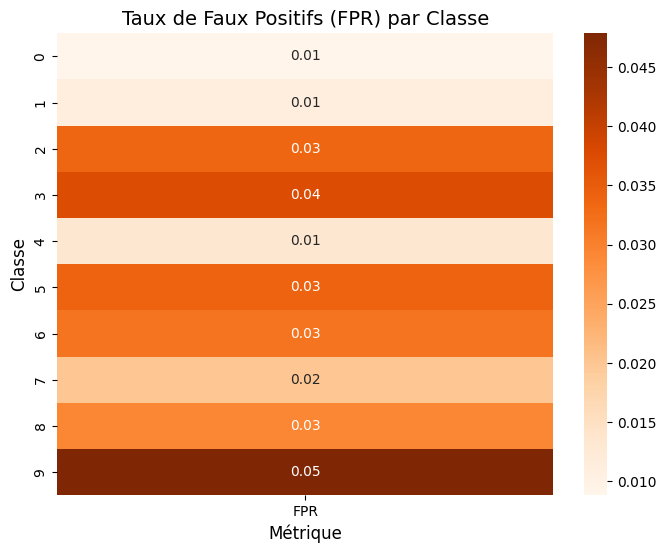

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul du taux de faux positifs (FPR) par classe
fpr_values = calcul_fpr(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(fpr_values.keys())
fpr_matrix = np.array(list(fpr_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fpr_matrix, annot=True, fmt=".2f", cmap="Oranges", xticklabels=["FPR"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Taux de Faux Positifs (FPR) par Classe", fontsize=14)

# Affichage
plt.show()

specificite

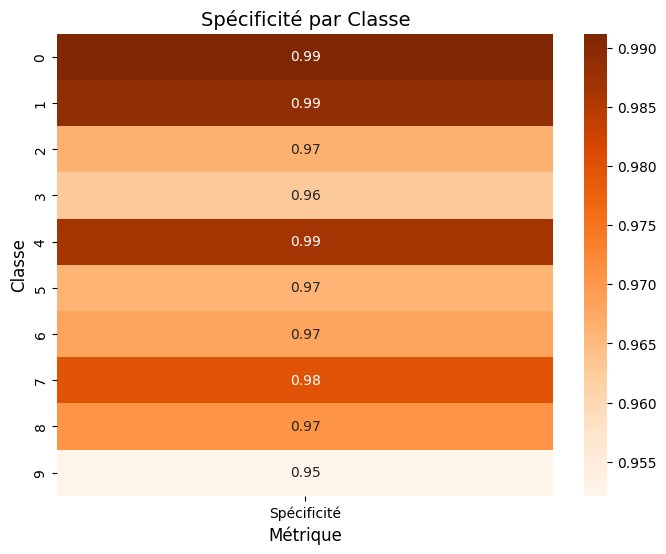

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la spécificité par classe
specificity_values = calcul_specificite(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(specificity_values.keys())
specificity_matrix = np.array(list(specificity_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(specificity_matrix, annot=True, fmt=".2f", cmap="Oranges", xticklabels=["Spécificité"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Spécificité par Classe", fontsize=14)

# Affichage
plt.show()


# Methode 3 : RN

In [ ]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [ ]:
# Choisir une image de test
c=0

In [ ]:
Y_pred = model.predict([Xtt[c,:]])

In [ ]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[2.90045275e-10, 1.67352475e-08, 6.68462289e-06, 3.41831293e-07,
        9.99984811e-01, 2.90418783e-08, 2.41193638e-10, 4.25132064e-06,
        3.98504283e-07, 3.46627823e-06]])

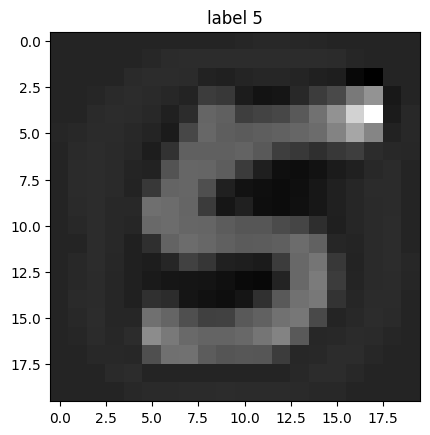

In [ ]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

Matrice confusion RN

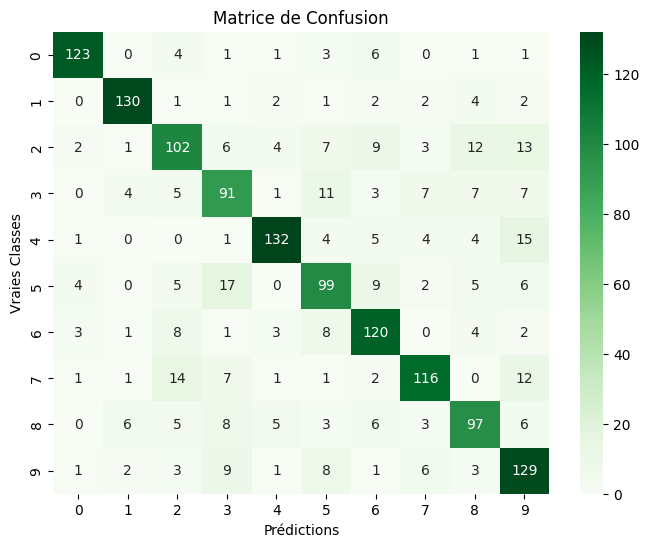

In [ ]:
import seaborn as sns

cm, metrics = matrice_confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")
df_metrics.index.name = "Classe"
df_metrics.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  123 │ 1348 │   12 │   17 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  130 │ 1340 │   15 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  102 │ 1296 │   45 │   57 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │   91 │ 1313 │   51 │   45 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  132 │ 1316 │   18 │   34 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │   99 │ 1307 │   46 │   48 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  120 │ 1307 │   43 │   30 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  116 │ 1318 │   27 │   39 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │   97 │ 1321 │   40 │   42 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  129 │ 1273 │   64 │   34 │
╘══════════╧══════╧══════╧══════╧══════╛


matrice confusion RN (Python)

In [ ]:
Ytt = np.where(Ytt == 10, 0, Ytt)
y_pred = np.where(y_pred == 10, 0, y_pred)

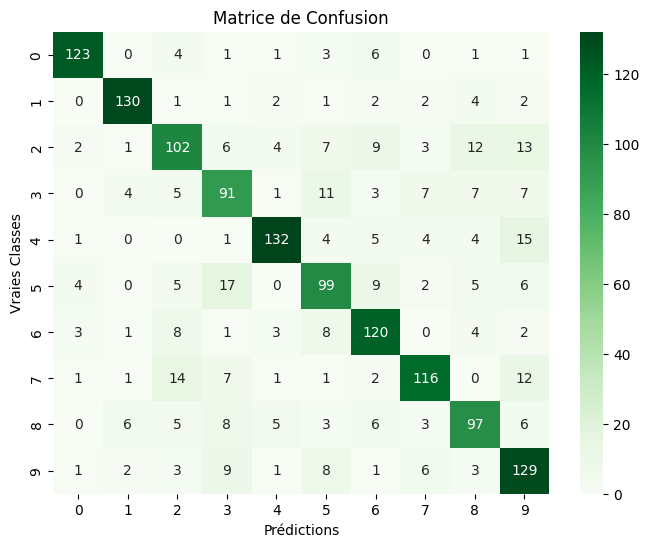

In [ ]:
cm1, metrics1 = confusion(Ytt, y_pred, num_classes=10)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Greens", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Pour un affichage propre dans la console

# Création d'un DataFrame pour afficher les métriques de manière organisée
df_metrics1 = pd.DataFrame.from_dict(metrics1, orient="index")
df_metrics1.index.name = "Classe"
df_metrics1.columns = ["TP", "TN", "FP", "FN"]

# Affichage en tableau structuré
print(tabulate(df_metrics1, headers="keys", tablefmt="fancy_grid"))

╒══════════╤══════╤══════╤══════╤══════╕
│   Classe │   TP │   TN │   FP │   FN │
╞══════════╪══════╪══════╪══════╪══════╡
│        0 │  123 │ 1348 │   12 │   17 │
├──────────┼──────┼──────┼──────┼──────┤
│        1 │  130 │ 1340 │   15 │   15 │
├──────────┼──────┼──────┼──────┼──────┤
│        2 │  102 │ 1296 │   45 │   57 │
├──────────┼──────┼──────┼──────┼──────┤
│        3 │   91 │ 1313 │   51 │   45 │
├──────────┼──────┼──────┼──────┼──────┤
│        4 │  132 │ 1316 │   18 │   34 │
├──────────┼──────┼──────┼──────┼──────┤
│        5 │   99 │ 1307 │   46 │   48 │
├──────────┼──────┼──────┼──────┼──────┤
│        6 │  120 │ 1307 │   43 │   30 │
├──────────┼──────┼──────┼──────┼──────┤
│        7 │  116 │ 1318 │   27 │   39 │
├──────────┼──────┼──────┼──────┼──────┤
│        8 │   97 │ 1321 │   40 │   42 │
├──────────┼──────┼──────┼──────┼──────┤
│        9 │  129 │ 1273 │   64 │   34 │
╘══════════╧══════╧══════╧══════╧══════╛


Metriques RN

Accuracy

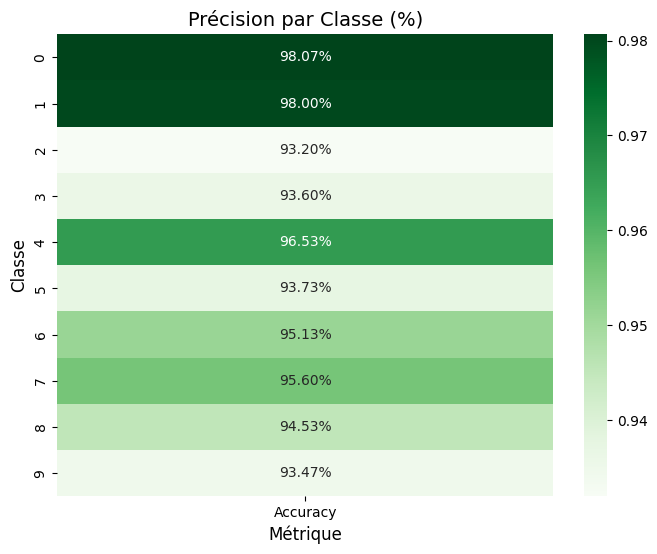

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
class_accuracies = calcul_accuracy(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(class_accuracies.keys())
accuracies = np.array(list(class_accuracies.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracies, annot=True, fmt=".2%", cmap="Greens", xticklabels=["Accuracy"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe (%)", fontsize=14)

# Affichage
plt.show()

Recall RN

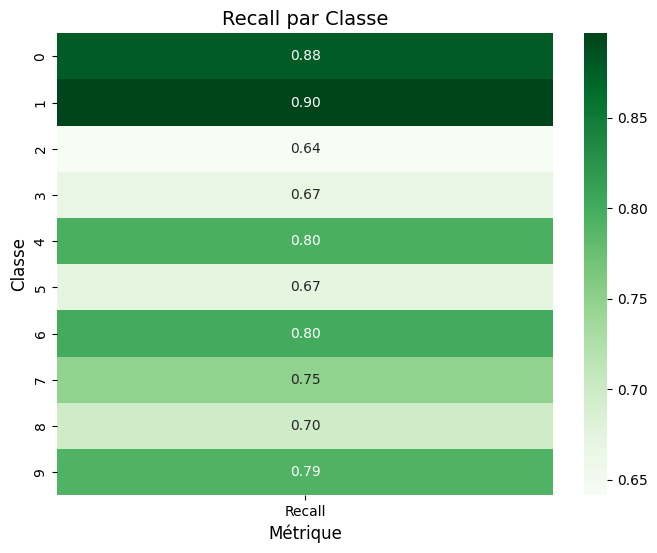

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des recalls par classe
recalls = calcul_recall(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(recalls.keys())
recall_values = np.array(list(recalls.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(recall_values, annot=True, fmt=".2f", cmap="Greens", xticklabels=["Recall"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Recall par Classe", fontsize=14)

# Affichage
plt.show()

Precision RN

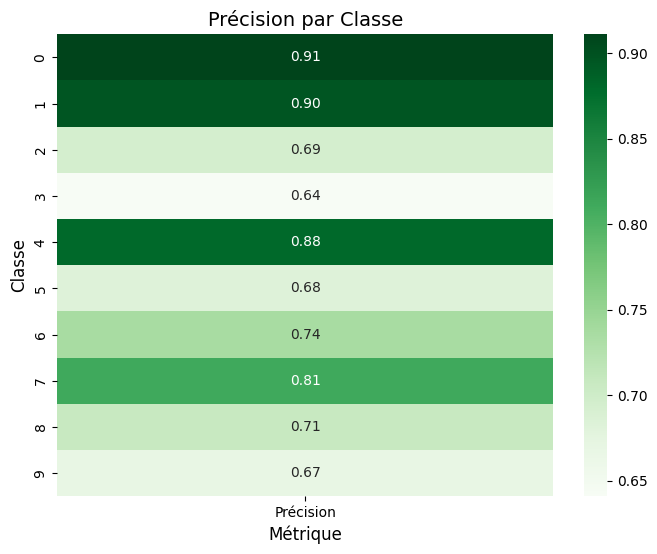

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des précisions par classe
precisions = calcul_precision(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(precisions.keys())
precision_values = np.array(list(precisions.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(precision_values, annot=True, fmt=".2f", cmap="Greens", xticklabels=["Précision"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Précision par Classe", fontsize=14)

# Affichage
plt.show()


Taux de FP RN

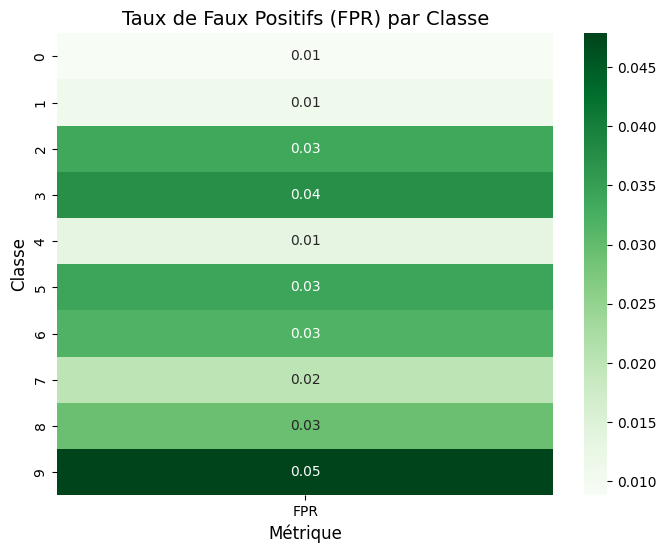

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul du taux de faux positifs (FPR) par classe
fpr_values = calcul_fpr(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(fpr_values.keys())
fpr_matrix = np.array(list(fpr_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fpr_matrix, annot=True, fmt=".2f", cmap="Greens", xticklabels=["FPR"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Taux de Faux Positifs (FPR) par Classe", fontsize=14)

# Affichage
plt.show()

Specificite RN

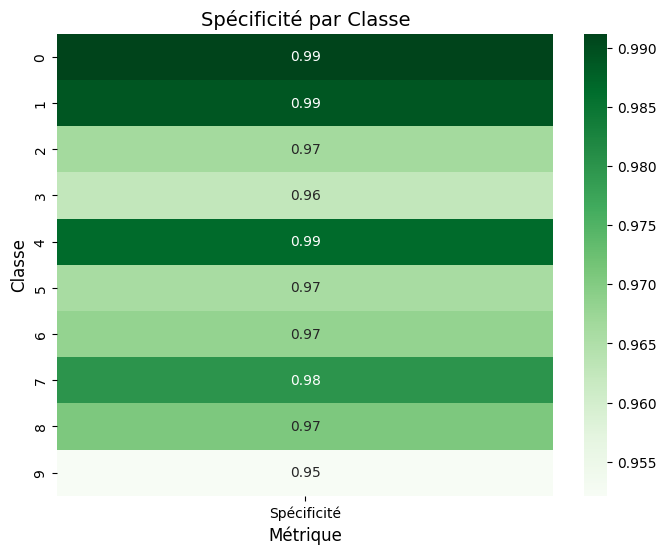

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la spécificité par classe
specificity_values = calcul_specificite(metrics)

# Transformation des données en format matriciel (tableau 2D)
classes = list(specificity_values.keys())
specificity_matrix = np.array(list(specificity_values.values())).reshape(-1, 1)  # Convertir en matrice colonne

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(specificity_matrix, annot=True, fmt=".2f", cmap="Greens", xticklabels=["Spécificité"], yticklabels=classes)

# Ajout des labels et titre
plt.xlabel("Métrique", fontsize=12)
plt.ylabel("Classe", fontsize=12)
plt.title("Spécificité par Classe", fontsize=14)

# Affichage
plt.show()


Courbe ROC

In [ ]:
Ytt = np.where(Ytt == 10, 0, Ytt)
y_pred = np.where(y_pred == 10, 0, y_pred)

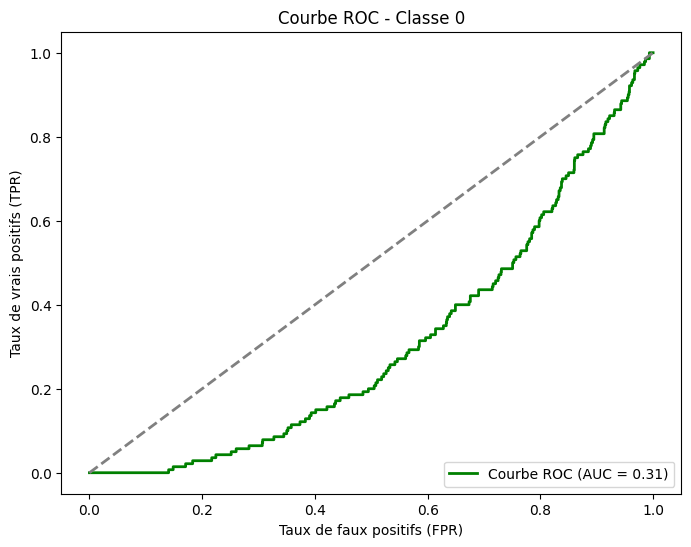

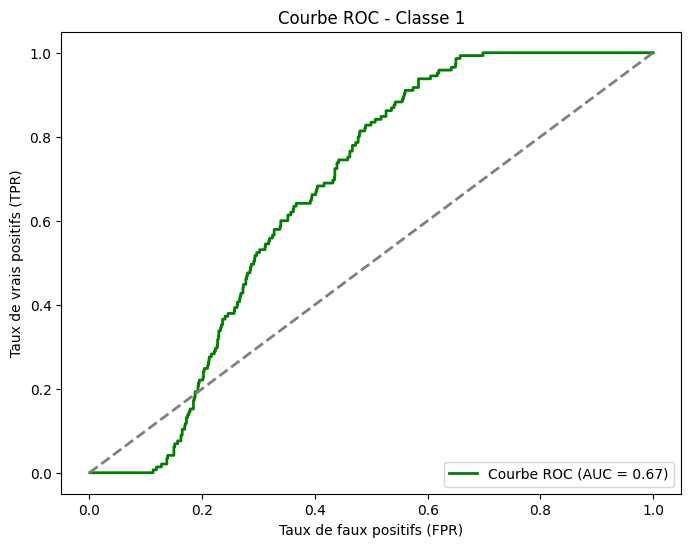

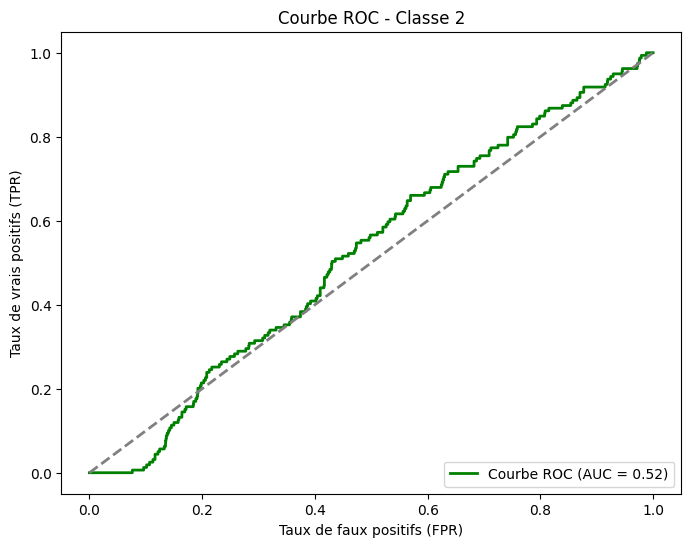

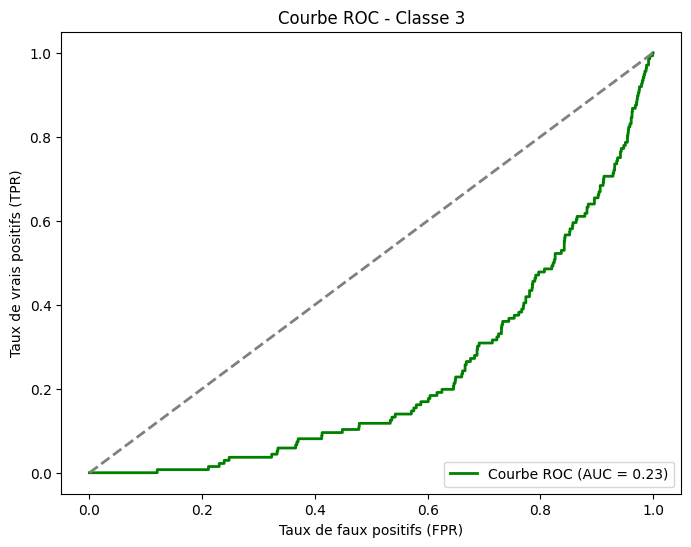

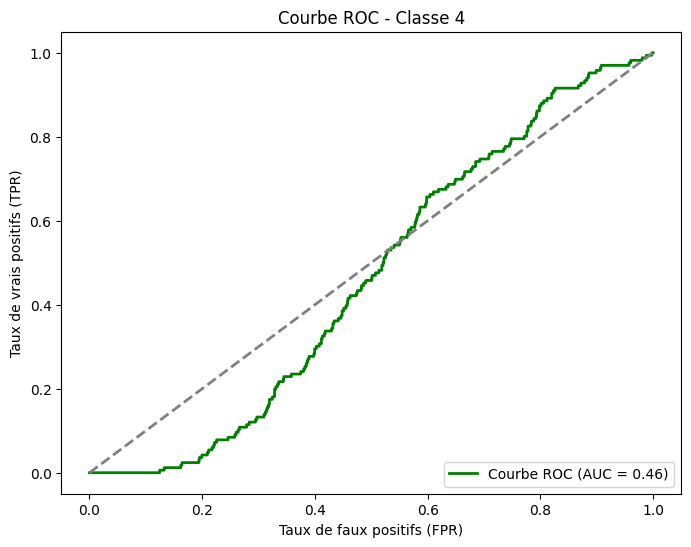

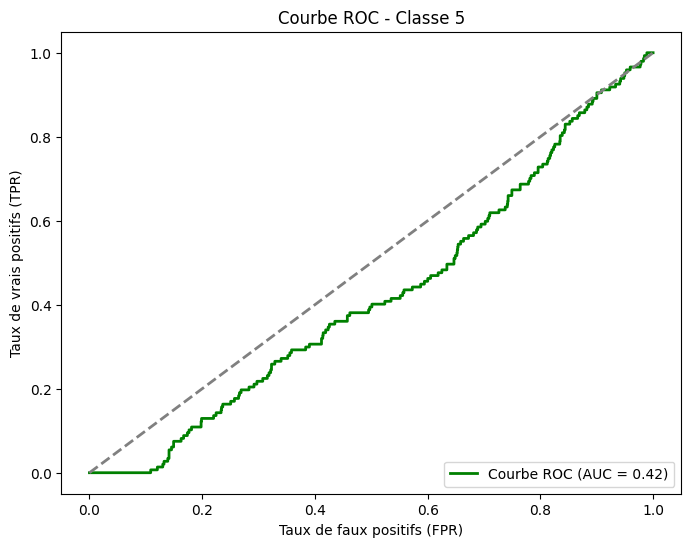

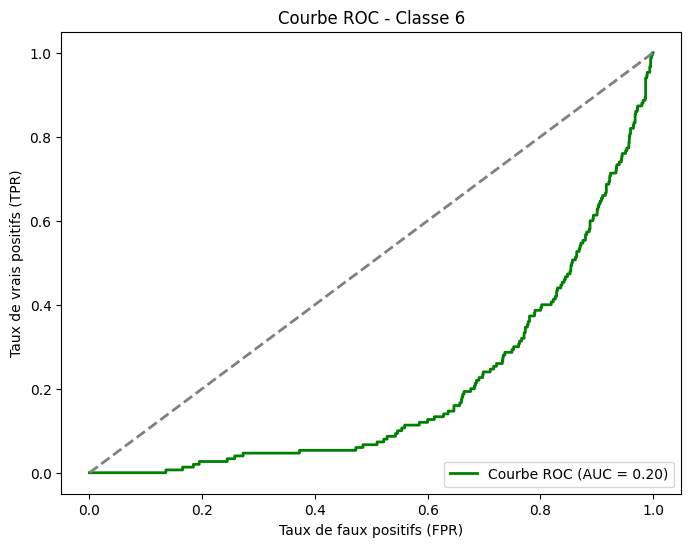

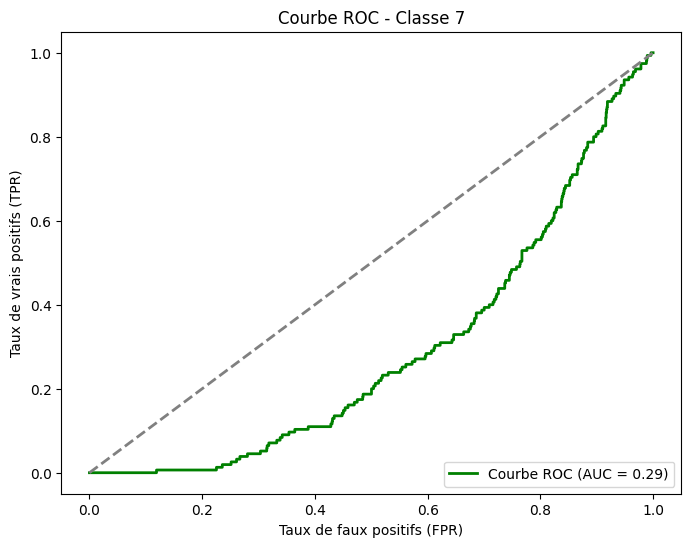

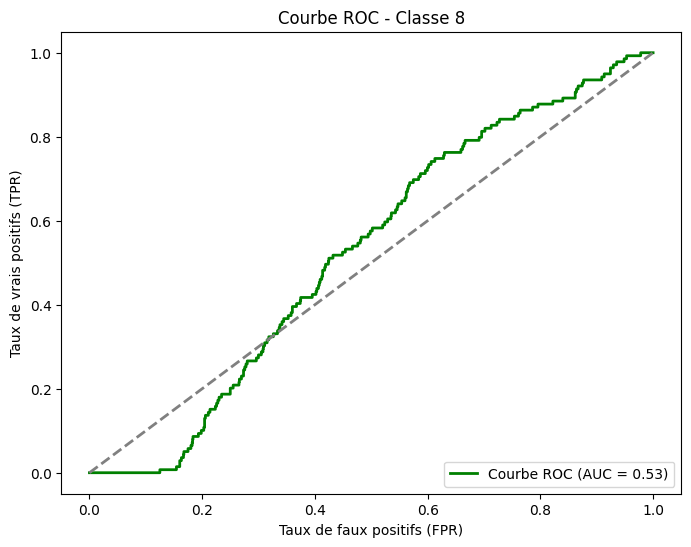

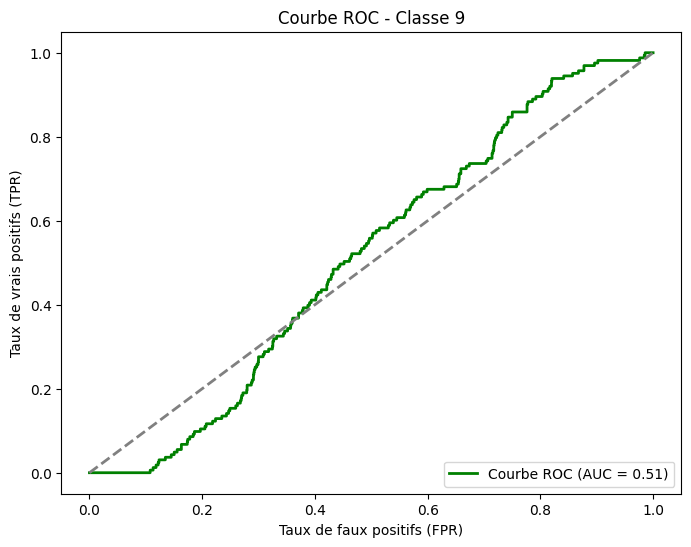

In [ ]:
for classe in range(10):  # Si tu as 10 classes (0 à 9)
    Y_scores = model.predict_proba(Xtt)
    Y_true = (Ytt == classe)  # One-vs-Rest (OvR
    calculer_courbe_roc_from_scratch(Y_true, Y_scores, classe)

version SKLEARN

In [ ]:
from sklearn.metrics import roc_curve, auc

def calculer_courbe_roc(y_true, y_scores,classe):
    """
    Calcule la courbe ROC et l'affiche pour un modèle donné.

    Paramètres:
    y_true (array-like): Les étiquettes réelles (vérités de terrain).
    y_scores (array-like): Les scores de prédiction du modèle (probabilités ou scores de classe).

    Retourne:
    fpr (array): Le taux de faux positifs.
    tpr (array): Le taux de vrais positifs.
    auc_score (float): L'aire sous la courbe ROC.
    """
    # Calcul de la courbe ROC
    y_scores_classe = y_scores[:,classe]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_classe)

    # Calcul de l'AUC (Area Under the Curve)
    auc_score = auc(fpr, tpr)

    # Affichage de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'Courbe ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale (prédiction aléatoire)
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title(f'Courbe ROC classe {classe}')
    plt.legend(loc='lower right')
    plt.show()

    return fpr, tpr, auc_score

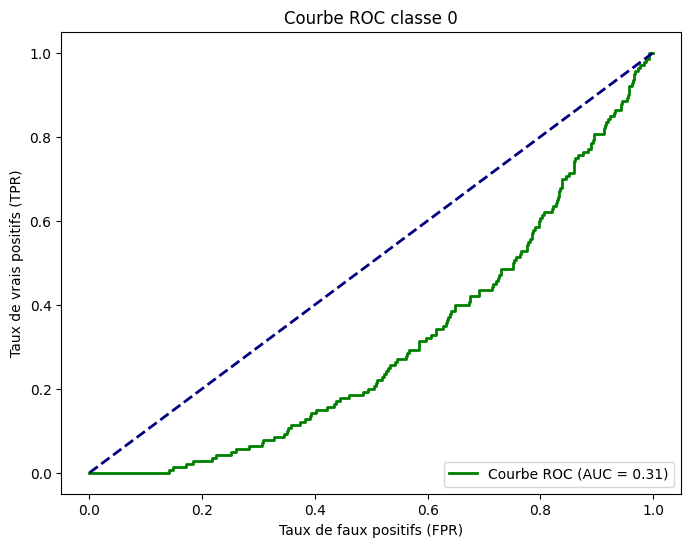

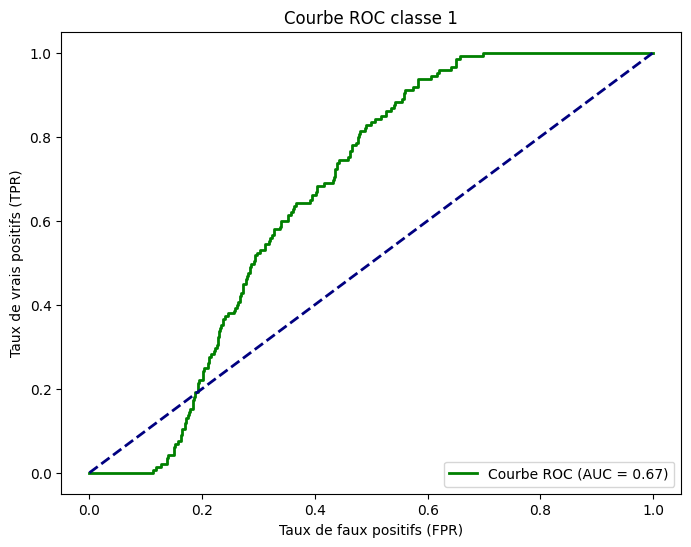

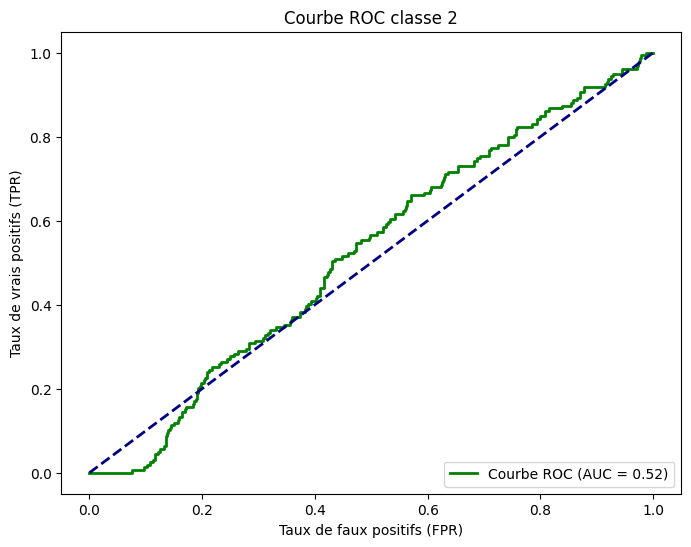

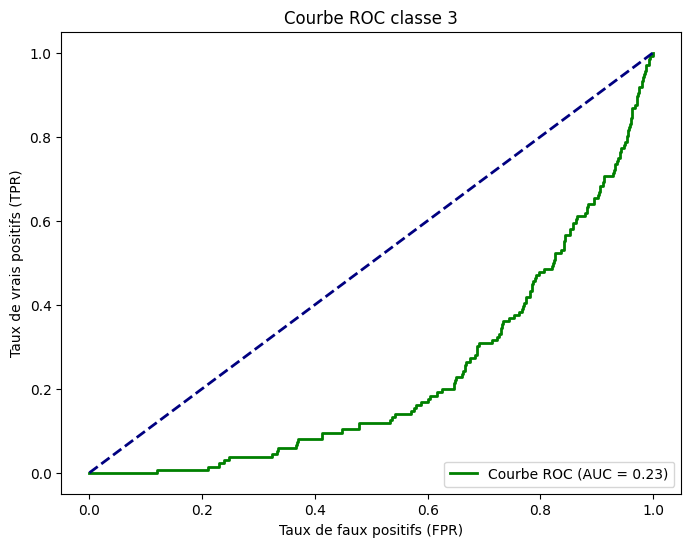

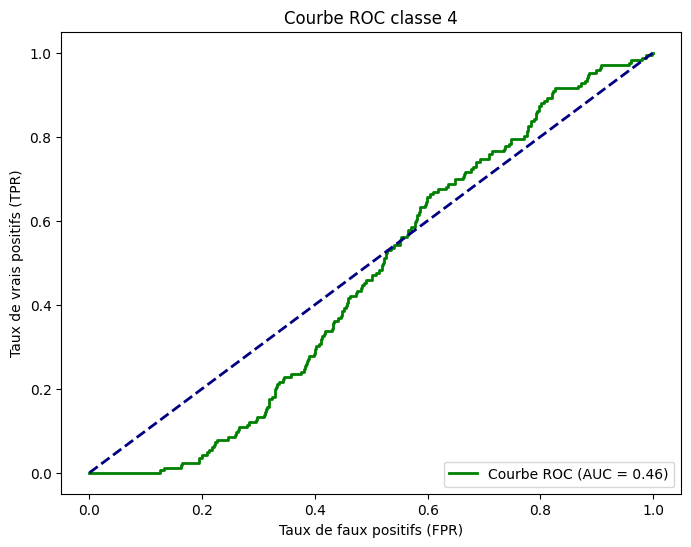

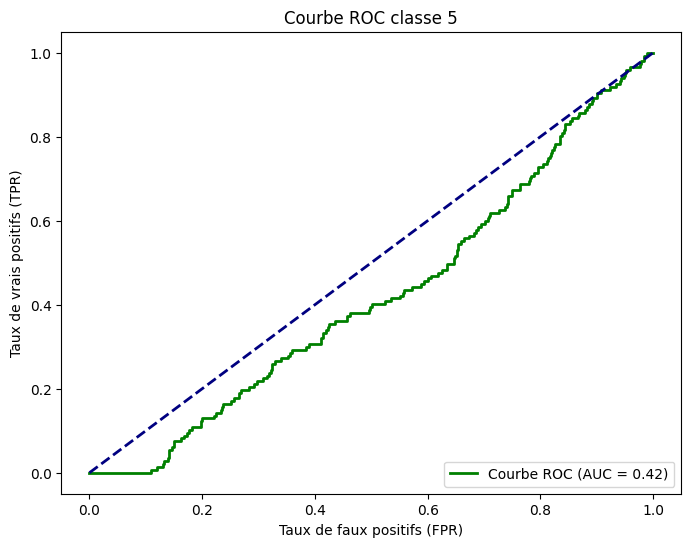

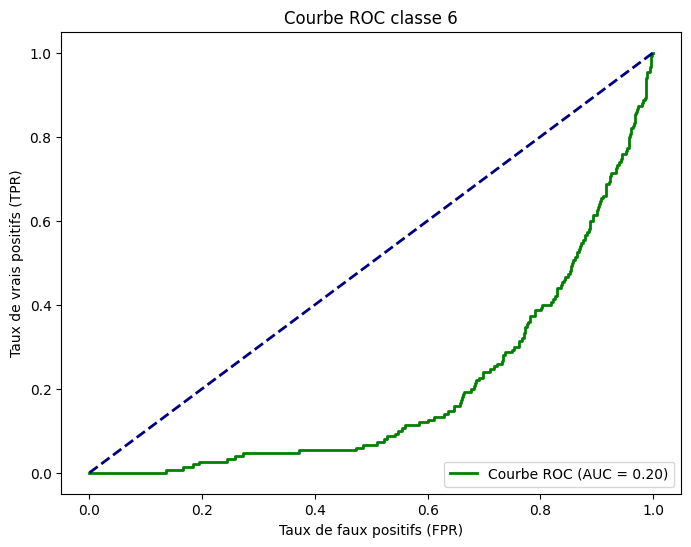

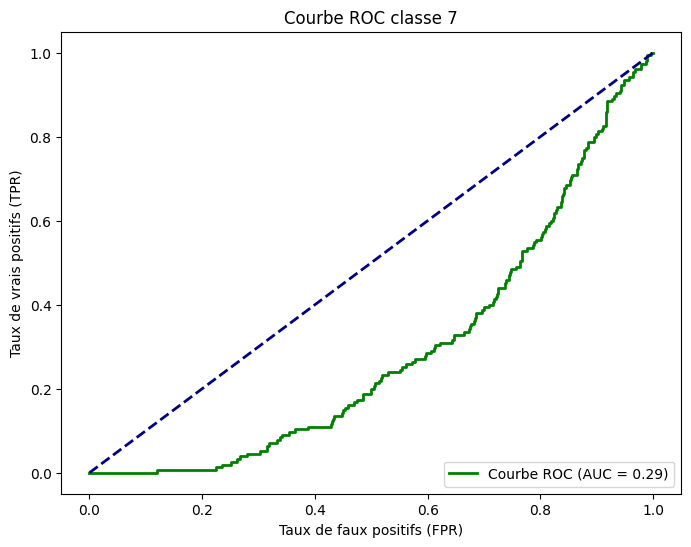

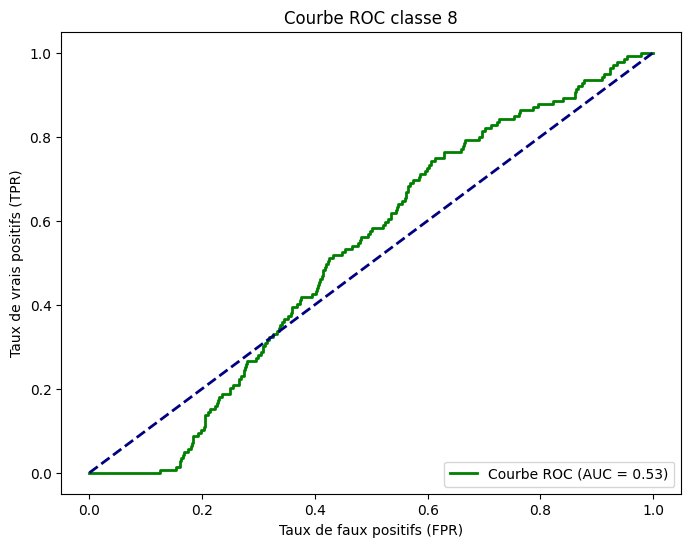

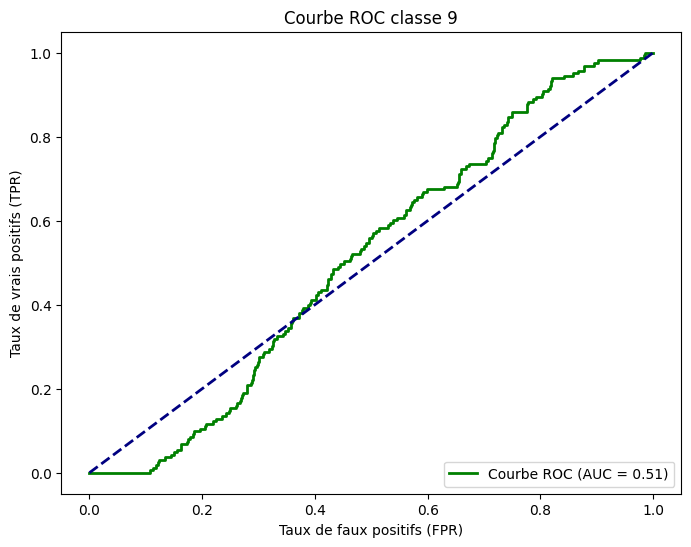

In [ ]:
for classe in range(10):  # Si tu as 10 classes (0 à 9)
    Y_scores = model.predict_proba(Xtt)
    Y_true = (Ytt == classe)  # One-vs-Rest (OvR
    calculer_courbe_roc(Y_true, Y_scores, classe)